In [1]:
import numpy as np
import os
import itertools
from skimage.transform import resize
from scipy.signal import medfilt

# Original dimensions: 70, 740, 856

# training data
image_path = 'numpy_data/Ultrasound Volumes/'
segmentation_path = 'numpy_data/Patient Segmentations/'
image_file_list = [image_path + f for f in os.listdir(image_path) if f.endswith('.npy')]
segmentation_file_list = [segmentation_path + f for f in os.listdir(segmentation_path) if f.endswith('.npy')]

# testing data
t_image_path = 'numpy_data/Ultrasound Volumes/Testing Data/'
t_segmentation_path = 'numpy_data/Patient Segmentations/Testing Data/'
t_image_file_list = [t_image_path + f for f in os.listdir(t_image_path) if f.endswith('.npy')]
t_segmentation_file_list = [t_segmentation_path + f for f in os.listdir(t_segmentation_path) if f.endswith('.npy')]


# determine uniform dimensions
def add_elements(dict, key, value1, value2):
    if key not in dict:
        dict[key] = []
    dict[key].append(value1)
    dict[key].append(value2)

dimensions = {}
for file in itertools.chain(segmentation_file_list, t_segmentation_file_list):
    segmentation_array = np.load(file)
    x, y, z = np.where(segmentation_array != 0)
    add_elements(dimensions, 'x', min(x), max(x))
    add_elements(dimensions, 'y', min(y), max(y))
    add_elements(dimensions, 'z', min(z), max(z))

# segmentation_array = segmentation_array[min(x):max(x)+1, min(y):max(y)+1, min(z):max(z)+1]
x_list = dimensions.get('x')
y_list = dimensions.get('y')
z_list = dimensions.get('z')

min_x = min(x_list)
max_x = max(x_list)
min_y = min(y_list)
max_y = max(y_list)
min_z = min(z_list)
max_z = max(z_list)

In [2]:
# crop and stack training arrays

segmentation_arrays = []
for file in segmentation_file_list:
    seg_arr = np.load(file)
    # crop image
    crop_arr = seg_arr[:, min(y):max(y)+1, min(z):max(z)+1]
    # resize image
    resized_arr = resize(crop_arr, (128, 128, 128), preserve_range=True)
    segmentation_array = np.expand_dims(resized_arr, 3)
    segmentation_arrays.append(segmentation_array)
    
    
image_arrays = []
for file in image_file_list:
    img_arr = np.load(file)
    # crop image
    crop_arr = img_arr[:, min(y):max(y)+1, min(z):max(z)+1]
    # resize image
    resized_arr = resize(crop_arr, (128, 128, 128), preserve_range=True)
    filt_arr = medfilt(resized_arr, kernel_size=3)
    image_array = np.expand_dims(filt_arr, 3)
    image_arrays.append(image_array)


stacked_image_array = np.stack(image_arrays)
stacked_segmentation_array = np.stack(segmentation_arrays)

print(stacked_image_array.shape)
print(stacked_segmentation_array.shape)

norm_img_arr = (stacked_image_array - np.min(stacked_image_array))/np.ptp(stacked_image_array)
norm_seg_arr = (stacked_segmentation_array - np.min(stacked_segmentation_array))/np.ptp(stacked_segmentation_array)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/stacked_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/stacked_segmentation_array'

np.save(image_file, norm_img_arr)
np.save(segmentation_file, norm_seg_arr)

(24, 128, 128, 128, 1)
(24, 128, 128, 128, 1)


In [3]:
# crop and stack testing arrays

segmentation_arrays = []
for file in t_segmentation_file_list:
    seg_arr = np.load(file)
    # crop image
    crop_arr = seg_arr[:, min(y):max(y)+1, min(z):max(z)+1]
    # resize image
    resized_arr = resize(crop_arr, (128, 128, 128), preserve_range=True)
    segmentation_array = np.expand_dims(resized_arr, 3)
    segmentation_arrays.append(segmentation_array)
    
    
image_arrays = []
for file in t_image_file_list:
    img_arr = np.load(file)
    # crop image
    crop_arr = img_arr[:, min(y):max(y)+1, min(z):max(z)+1]
    # resize image
    resized_arr = resize(crop_arr, (128, 128, 128), preserve_range=True)
    filt_arr = medfilt(resized_arr, kernel_size=3)
    image_array = np.expand_dims(filt_arr, 3)
    image_arrays.append(image_array)


t_stacked_image_array = np.stack(image_arrays)
t_stacked_segmentation_array = np.stack(segmentation_arrays)

print(t_stacked_image_array.shape)
print(t_stacked_segmentation_array.shape)

t_norm_img_arr = (t_stacked_image_array - np.min(t_stacked_image_array))/np.ptp(t_stacked_image_array)
t_norm_seg_arr = (t_stacked_segmentation_array - np.min(t_stacked_segmentation_array))/np.ptp(t_stacked_segmentation_array)

# export as numpy files
image_file = 'numpy_data/Stacked Arrays/test_image_array'
segmentation_file = 'numpy_data/Stacked Arrays/test_segmentation_array'

np.save(image_file, t_norm_img_arr)
np.save(segmentation_file, t_norm_seg_arr)

(6, 128, 128, 128, 1)
(6, 128, 128, 128, 1)


In [4]:
%matplotlib notebook

In [5]:
import matplotlib.pyplot as plt

test_array = np.load('numpy_data/Ultrasound Volumes/ultrasound03.npy')
test_array2 = np.load('numpy_data/Patient Segmentations/brachy_patient03.npy')
# plt.imshow(test_array[11])

In [6]:
# Multi-slice view code extracted and adapted from: https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

(108, 740, 856)


<IPython.core.display.Javascript object>


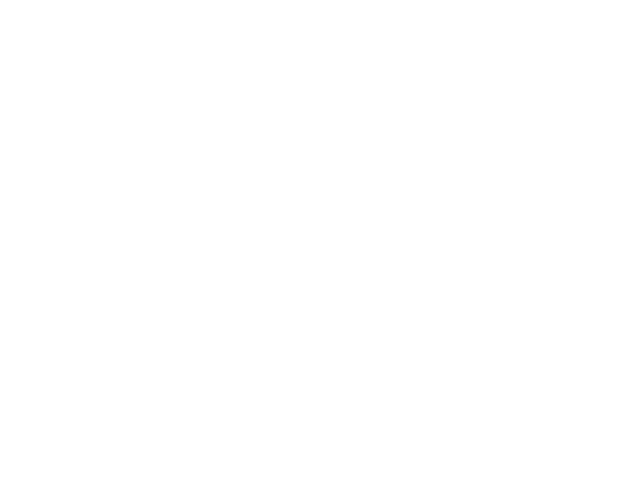

In [7]:
# cropped_arr = test_array[min_x:max_x+1, :, :]
from skimage.transform import resize
from scipy.signal import medfilt
import numpy as np

print(test_array.shape)
x = resize(test_array2, (128, 128, 128), preserve_range=True)
# xx = medfilt(x, kernel_size=5)
multi_slice_viewer(x)

(128, 128, 128, 1)


<IPython.core.display.Javascript object>


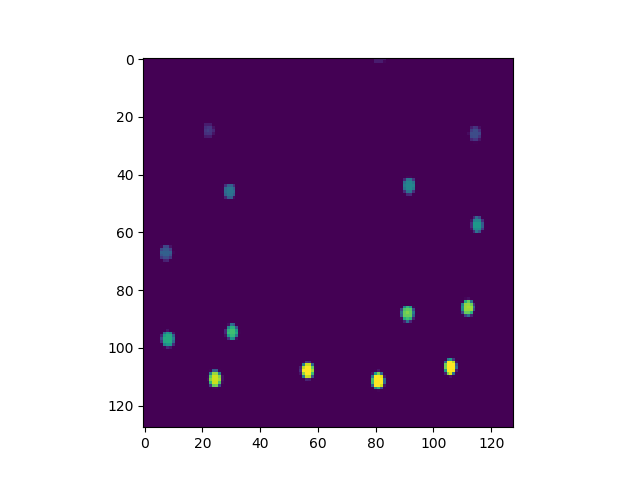

In [13]:
arr = norm_seg_arr[2]
print(arr.shape)
multi_slice_viewer(arr[:, :, :, 0])

In [9]:
%matplotlib notebook

(108, 740, 856)
(108, 366, 502)


<IPython.core.display.Javascript object>


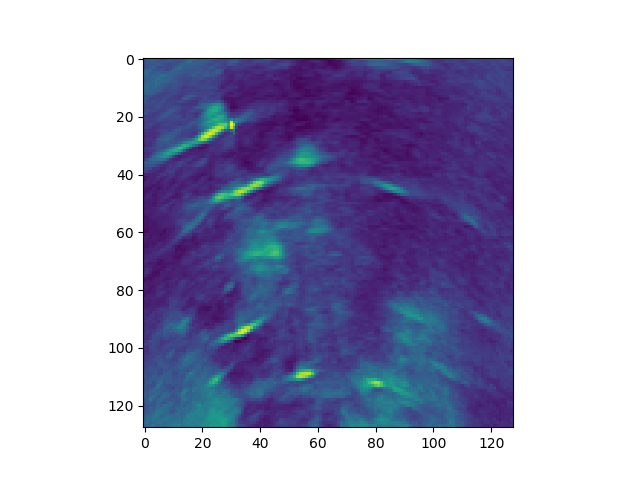

In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = np.load('numpy_data/Ultrasound Volumes/ultrasound03.npy')
# image = resize(image, (128, 128, 128), preserve_range=True)
print(image.shape)

'''
alpha = 1.3 # Simple contrast control
beta = 40    # Simple brightness control

new_image = np.zeros(image.shape, image.dtype)

for idx in range(len(image)):
    img_slice = image[idx, :, :]
    new_slice = cv.convertScaleAbs(img_slice, alpha=alpha, beta=beta)
    new_image[idx, :, :] = new_slice
'''

arr = image[:, min(y):max(y)+1, min(z):max(z)+1]
print(arr.shape)
image = resize(arr, (128, 128, 128), preserve_range=True)
multi_slice_viewer(image)

<IPython.core.display.Javascript object>


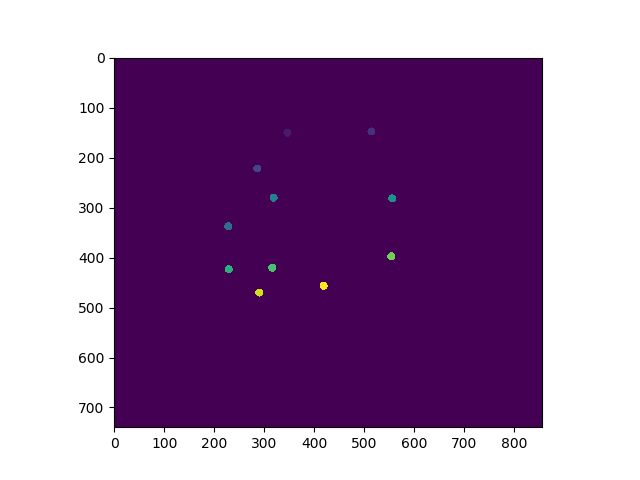

In [11]:
seg = np.load('numpy_data/Patient Segmentations/brachy_patient03.npy')

multi_slice_viewer(seg)